# Interlude: How Least Squares Solutions Are Solved Numerically

We want to solve a linear least squares problem:

$$
\min_x \|Ax - b\|_2^2,
$$

where \(A \in \mathbb{R}^{m \times n}\) (with \(m \geq n\)), \(x \in \mathbb{R}^n\), and \(b \in \mathbb{R}^m\).

---

## 1. Normal Equations (theoretical but numerically weak)

Set the gradient to zero:

$$
A^T A x = A^T b.
$$

Then solve for \(x\).

- **Pros**: Simple, easy to derive.  
- **Cons**:  
  - Squaring the condition number of \(A\) → numerical instability.  
  - Requires forming \(A^T A\), which can lose precision.

👉 Rarely used directly in modern numerical libraries.

---

## 2. QR Factorization (most common in practice)

Factorize:

$$
A = QR,
$$

where:
- \(Q \in \mathbb{R}^{m \times n}\) has orthonormal columns,  
- \(R \in \mathbb{R}^{n \times n}\) is upper triangular.

Then:

$$
\min_x \|Ax - b\|_2 = \min_x \|Rx - Q^T b\|_2.
$$

This reduces to solving the triangular system:

$$
R x = Q^T b.
$$

- **Pros**: Stable, efficient.  
- **How**: Computed using **Householder reflections** or **Givens rotations**.

---

## 3. Singular Value Decomposition (SVD)

Factorize:

$$
A = U \Sigma V^T,
$$

where \(\Sigma\) contains the singular values.  
The solution is:

$$
x = V \Sigma^+ U^T b,
$$

with \(\Sigma^+\) the Moore–Penrose pseudoinverse.

- **Pros**:  
  - Most accurate.  
  - Handles rank deficiency (when \(A\) is not full rank).  
- **Cons**: More computationally expensive.

---

## 4. Iterative Methods (for large/sparse problems)

When \(A\) is huge, factorizations aren’t feasible. Iterative solvers are used, which only need matrix-vector products with \(A\) and \(A^T\):

- **CGNE** (Conjugate Gradient for Normal Equations)  
- **CGLS** (Conjugate Gradient for Least Squares)  
- **LSQR** (Lanczos bidiagonalization, stable and widely used)  

- **Pros**: Scales to very large and sparse systems.  
- **Cons**: Convergence can depend on conditioning.

---

## ✅ Summary

- **Small/medium dense problems** → **QR factorization** (default in NumPy, MATLAB, LAPACK).  
- **Ill-conditioned or rank-deficient problems** → **SVD**.  
- **Huge/sparse problems** → **Iterative methods** (LSQR, CGLS).  
- **Normal equations** → Mostly theoretical, not recommended in practice.


## Inverse Problem for a Strike-Slip Fault Using the Screw Dislocation Model

**Problem Statement:**

In this exercise, we will use the antiplane screw dislocation model to simulate and invert for slip on a vertical, surface-breaking strike-slip fault. The fault is discretized into two patches, each with uniform slip. We will generate synthetic surface displacement data, add noise, and use the normal equations to estimate the slip on each patch from the noisy data.

**Physical Model:**

The antiplane screw dislocation solution gives the surface displacement $u(x)$ at a horizontal distance $x$ from the fault due to a vertical strike-slip dislocation (fault) extending from depth $d_1$ to $d_2$ with slip $s$:

$$
u(x; d_1, d_2, s) = \frac{s}{\pi} \left[ \arctan\left(\frac{x}{d_1}\right) - \arctan\left(\frac{x}{d_2}\right) \right]$$

where:
- $x$ = horizontal distance from the fault (km)
- $d_1$, $d_2$ = top and bottom depths of the slip patch (km)
- $s$ = slip on the patch (meters)

The total surface displacement is the sum of contributions from all slip patches. The goal is to invert for the slip on each patch given noisy surface displacement data.

**Tasks:**
- Generate synthetic data using the forward model.
- Add noise to simulate measurement errors.
- Use the normal equations to solve for the slip on each patch.
- Interpret the results and discuss the effect of noise and model discretization.

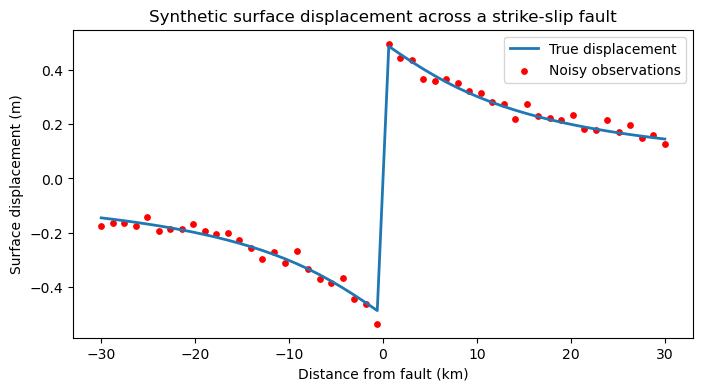

In [2]:
import numpy as np
import matplotlib.pyplot as plt

# Parameters
L = 20.0  # Fault length (km)
depths = [0, 10, 20]  # Patch boundaries (km)
x_obs = np.linspace(-30, 30, 50)  # Observation points at surface (km)
mu = 30e3  # Shear modulus (MPa)
slip_true = np.array([1.0, 0.5])  # True slip on each patch (meters)

def screw_dislocation_surface_disp(x, d1, d2, slip):
    # Returns surface displacement at x due to slip on a patch from d1 to d2
    # Okada solution for surface-breaking vertical strike-slip
    return (slip / np.pi) * (np.arctan2(x, d1) - np.arctan2(x, d2))

# Build forward matrix G
G = np.zeros((len(x_obs), 2))
for i in range(2):
    G[:, i] = screw_dislocation_surface_disp(x_obs, depths[i], depths[i+1], 1.0)

# Generate synthetic data
d_obs = G @ slip_true
noise = np.random.normal(0, 0.02, size=d_obs.shape)  # Add noise (2 cm std)
d_noisy = d_obs + noise

# Plot synthetic data
plt.figure(figsize=(8, 4))
plt.plot(x_obs, d_obs, label='True displacement', lw=2)
plt.scatter(x_obs, d_noisy, color='red', s=15, label='Noisy observations')
plt.xlabel('Distance from fault (km)')
plt.ylabel('Surface displacement (m)')
plt.legend()
plt.title('Synthetic surface displacement across a strike-slip fault')
plt.show()

In [ ]:
# Solve normal equations: m = (G^T G)^(-1) G^T d
GTG = G.T @ G
GTd = G.T @ d_noisy
slip_est = np.linalg.inv(GTG) @ GTd

print("Estimated slip on each patch (m):", slip_est)
print("True slip on each patch (m):", slip_true)

Patches: 2, Condition number of GTG: 2.10e+01
  Estimated slip (first 5): [0.97813496 0.52942697] ...


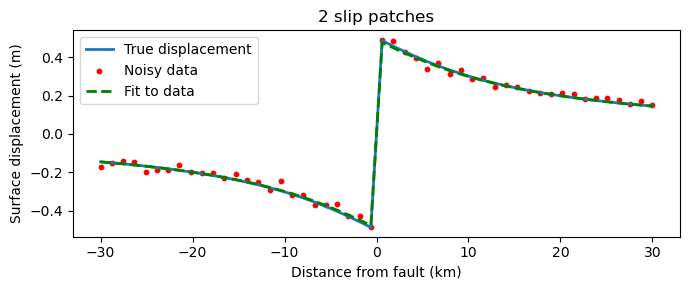

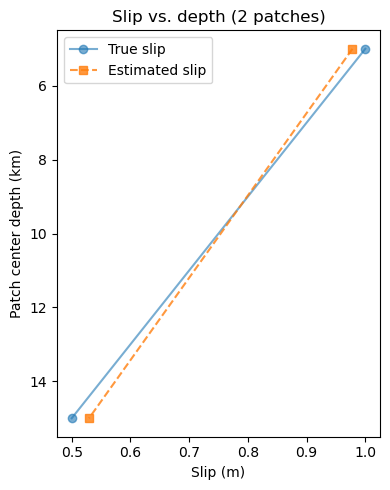

Patches: 3, Condition number of GTG: 7.37e+02
  Estimated slip (first 5): [0.99582073 0.19462367 0.89554591] ...


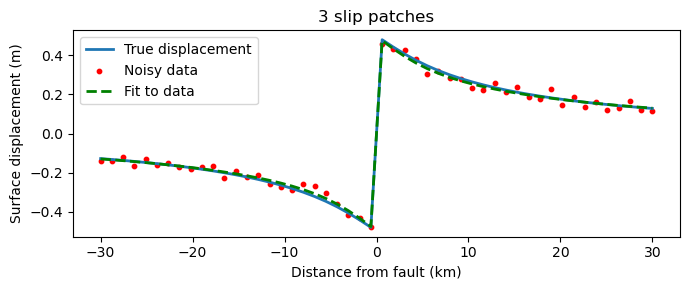

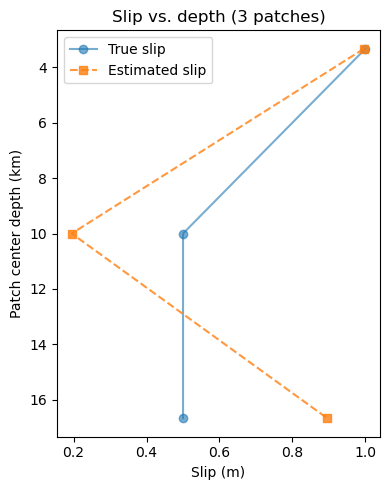

Patches: 4, Condition number of GTG: 2.96e+04
  Estimated slip (first 5): [0.99819893 0.63938288 0.19700431 0.58764669] ...


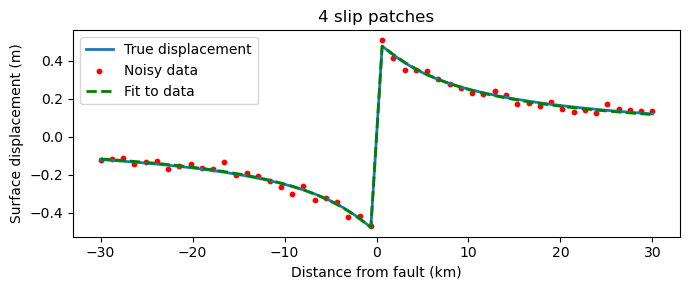

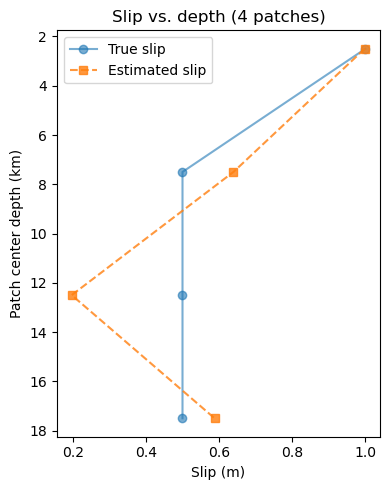

Patches: 5, Condition number of GTG: 1.24e+06
  Estimated slip (first 5): [ 1.05520389 -0.58546574  4.24052717 -4.21897939  2.48610901] ...


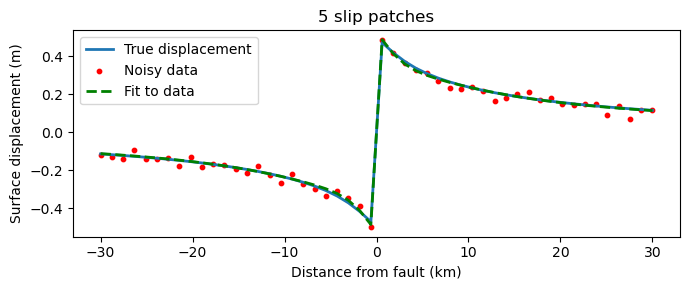

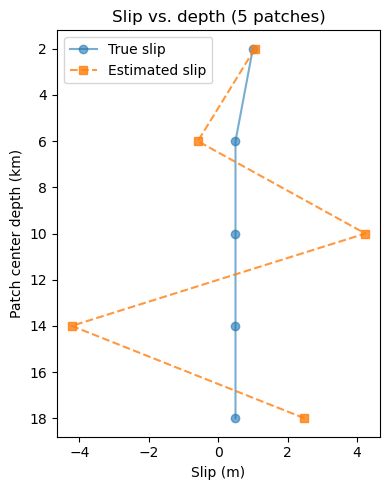

Patches: 6, Condition number of GTG: 5.35e+07
  Estimated slip (first 5): [  0.95992786   2.06648028 -12.28688853  38.0426548  -44.45867227] ...


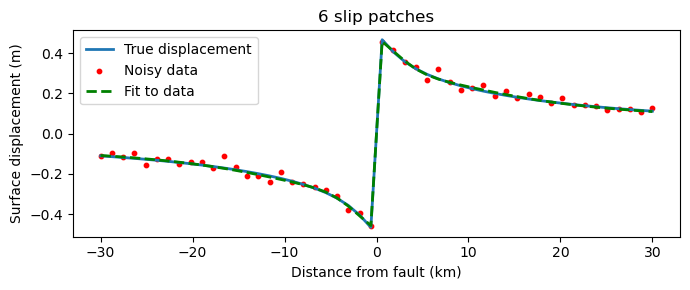

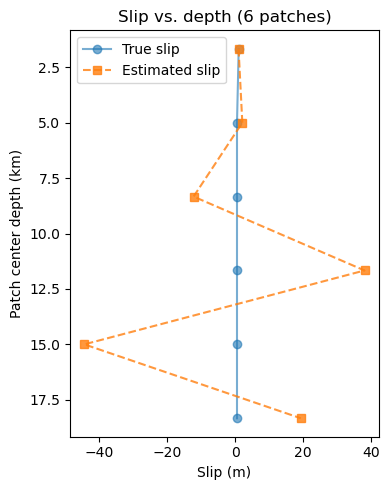

Patches: 7, Condition number of GTG: 2.36e+09
  Estimated slip (first 5): [   1.0853957    -2.37339453   31.20346679 -156.43324018  402.64099462] ...


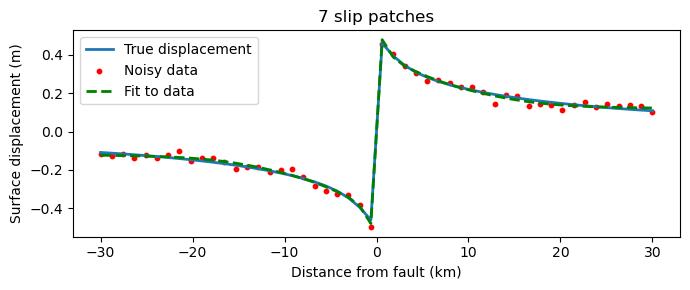

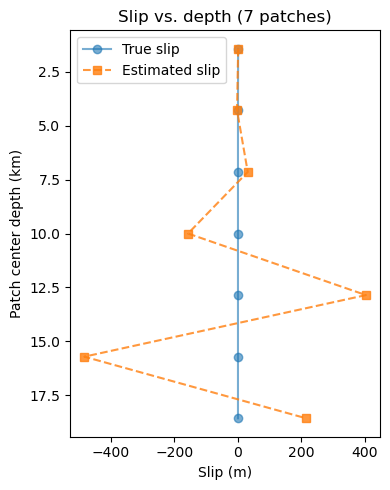

Patches: 8, Condition number of GTG: 1.08e+11
  Estimated slip (first 5): [ 1.09002982e+00 -8.65162891e+00  1.22291117e+02 -6.19661537e+02
  1.57233572e+03] ...


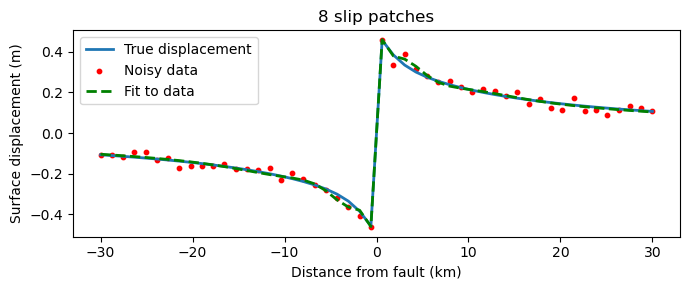

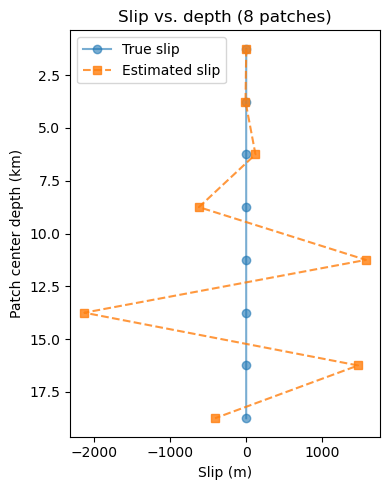

Patches: 9, Condition number of GTG: 5.23e+12
  Estimated slip (first 5): [ 9.92414464e-01 -3.01874487e+00  1.06779312e+02 -1.01752477e+03
  4.60399161e+03] ...


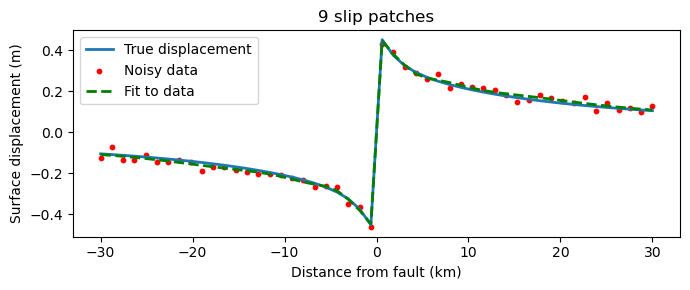

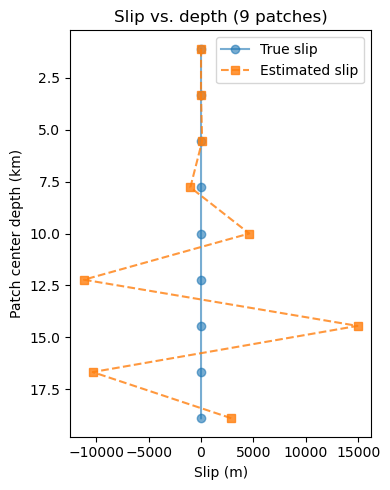

Problem becomes ill-posed at 9 patches (condition number > 1e+12)


In [5]:
# Explore ill-posedness as the number of slip patches increases
import numpy as np
import matplotlib.pyplot as plt

# Parameters
n_obs = 50
x_obs = np.linspace(-30, 30, n_obs)
max_patches = 30  # Try up to 30 slip patches
illposed_threshold = 1e12  # Condition number threshold for ill-posedness

illposed_found = False
for n_patches in range(2, max_patches+1):
    # Define patch boundaries (evenly spaced from 0 to 20 km depth)
    depths = np.linspace(0, 20, n_patches+1)
    patch_centers = 0.5 * (depths[:-1] + depths[1:])
    # True slip: 1.0 on first patch, 0.5 on others (arbitrary)
    slip_true = np.ones(n_patches) * 0.5
    slip_true[0] = 1.0
    # Build forward matrix G
    G = np.zeros((len(x_obs), n_patches))
    for i in range(n_patches):
        G[:, i] = (1/np.pi) * (np.arctan2(x_obs, depths[i]) - np.arctan2(x_obs, depths[i+1]))
    # Generate synthetic data
    d_obs = G @ slip_true
    noise = np.random.normal(0, 0.02, size=d_obs.shape)
    d_noisy = d_obs + noise
    # Compute GTG and its condition number
    GTG = G.T @ G
    cond_num = np.linalg.cond(GTG)
    # Solve the inverse problem (if not ill-posed)
    try:
        slip_est = np.linalg.inv(GTG) @ (G.T @ d_noisy)
        d_fit = G @ slip_est
    except np.linalg.LinAlgError:
        print(f"Patches: {n_patches}, GTG is singular (ill-posed)")
        break
    print(f"Patches: {n_patches}, Condition number of GTG: {cond_num:.2e}")
    print(f"  Estimated slip (first 5): {slip_est[:5]} ...")
    # Plot fit to data
    plt.figure(figsize=(7, 3))
    plt.plot(x_obs, d_obs, label='True displacement', lw=2)
    plt.scatter(x_obs, d_noisy, color='red', s=10, label='Noisy data')
    plt.plot(x_obs, d_fit, label='Fit to data', color='green', lw=2, linestyle='--')
    plt.title(f'{n_patches} slip patches')
    plt.xlabel('Distance from fault (km)')
    plt.ylabel('Surface displacement (m)')
    plt.legend()
    plt.tight_layout()
    plt.show()
    # Plot slip vs. patch center depth
    plt.figure(figsize=(4, 5))
    plt.plot(slip_true, patch_centers, 'o-', label='True slip', alpha=0.6)
    plt.plot(slip_est, patch_centers, 's--', label='Estimated slip', alpha=0.8)
    plt.gca().invert_yaxis()
    plt.xlabel('Slip (m)')
    plt.ylabel('Patch center depth (km)')
    plt.title(f'Slip vs. depth ({n_patches} patches)')
    plt.legend()
    plt.tight_layout()
    plt.show()
    if cond_num > illposed_threshold:
        print(f"Problem becomes ill-posed at {n_patches} patches (condition number > {illposed_threshold:.0e})")
        illposed_found = True
        break

if not illposed_found:
    print(f"No ill-posedness detected up to {max_patches} patches (condition number < {illposed_threshold:.0e})")

### Derivation of the Minimum Norm Solution
Consider the underdetermined linear system:
$$
\mathbf{G} \mathbf{m} = \mathbf{d}
$$
where $\mathbf{G}$ is an $N \times M$ matrix with $N < M$ (more unknowns than equations). There are infinitely many solutions for $\mathbf{m}$ that satisfy the data exactly (if the system is consistent).

The **minimum norm solution** is the solution $\mathbf{m}_\text{min}$ with the smallest Euclidean norm $\|\mathbf{m}\|_2$ among all possible solutions. This is often desirable when we want the "simplest" or least energetic solution.

#### Derivation:
The general solution to $\mathbf{G} \mathbf{m} = \mathbf{d}$ can be written as:
$$
\mathbf{m} = \mathbf{m}_p + \mathbf{n}
$$
where $\mathbf{m}_p$ is a particular solution and $\mathbf{n}$ is any vector in the null space of $\mathbf{G}$ (i.e., $\mathbf{G} \mathbf{n} = 0$).

To find the minimum norm solution, we minimize $\|\mathbf{m}\|_2^2$ subject to $\mathbf{G} \mathbf{m} = \mathbf{d}$. This is a constrained optimization problem, which can be solved using Lagrange multipliers:
$$
L(\mathbf{m}, \boldsymbol{\lambda}) = \frac{1}{2} \|\mathbf{m}\|_2^2 + \boldsymbol{\lambda}^T (\mathbf{d} - \mathbf{G} \mathbf{m})
$$
Setting the gradient with respect to $\mathbf{m}$ to zero:
$$
\nabla_{\mathbf{m}} L = \mathbf{m} - \mathbf{G}^T \boldsymbol{\lambda} = 0 \implies \mathbf{m} = \mathbf{G}^T \boldsymbol{\lambda}
$$
Substitute into the constraint:
$$
\mathbf{G} \mathbf{m} = \mathbf{G} \mathbf{G}^T \boldsymbol{\lambda} = \mathbf{d} \implies \boldsymbol{\lambda} = (\mathbf{G} \mathbf{G}^T)^{-1} \mathbf{d}
$$
Therefore, the minimum norm solution is:
$$
\boxed{\mathbf{m}_\text{min} = \mathbf{G}^T (\mathbf{G} \mathbf{G}^T)^{-1} \mathbf{d}}
$$
This is also known as the Moore-Penrose pseudoinverse solution: $\mathbf{m}_\text{min} = \mathbf{G}^+ \mathbf{d}$, where $\mathbf{G}^+ = \mathbf{G}^T (\mathbf{G} \mathbf{G}^T)^{-1}$.

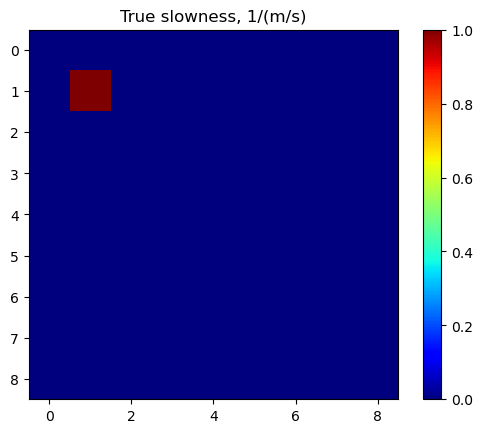

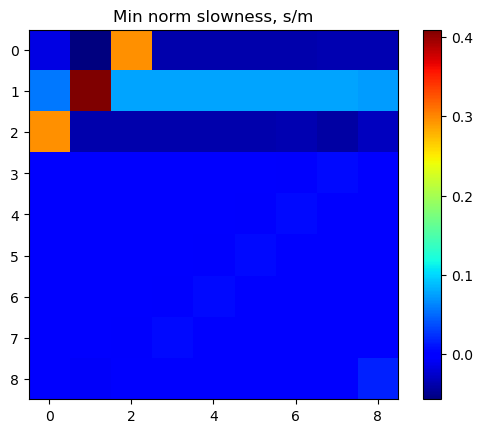

In [ ]:
# Toy minimum norm tomography inversion 
import numpy as np
import matplotlib.pyplot as plt

# Number of rows and columns of grid
numrows = 9
numcols = 9

# Assign slowness values to cells
B = np.zeros((numrows, numcols))
B[1, 1] = 1  # Python is 0-indexed

# Add some noise
B = B + 0.0 * np.random.randn(*B.shape)

cell_length = 1  # m

# Plot true slowness
plt.figure()
plt.imshow(B, cmap='jet', origin='upper')
plt.colorbar()
plt.title('True slowness, 1/(m/s)')
plt.show()

# --- Helper function to build G matrices for horizontal, vertical, and diagonal scans ---
def make_scanG(numrows, numcols, cell_length):
    N = numrows * numcols
    Ghz = []
    Gvert = []
    G1diag = []
    G2diag = []
    # Horizontal scans
    for i in range(numrows):
        row = np.zeros(N)
        for j in range(numcols):
            row[i * numcols + j] = cell_length
        Ghz.append(row)
    # Vertical scans
    for j in range(numcols):
        row = np.zeros(N)
        for i in range(numrows):
            row[i * numcols + j] = cell_length
        Gvert.append(row)
    # Diagonal (\) scans
    for k in range(numrows + numcols - 1):
        row = np.zeros(N)
        for i in range(numrows):
            j = k - i
            if 0 <= j < numcols:
                row[i * numcols + j] = cell_length
        if np.any(row):
            G1diag.append(row)
    # Diagonal (/) scans
    for k in range(-numrows + 1, numcols):
        row = np.zeros(N)
        for i in range(numrows):
            j = i + k
            if 0 <= j < numcols:
                row[i * numcols + j] = cell_length
        if np.any(row):
            G2diag.append(row)
    return np.array(Ghz), np.array(Gvert), np.array(G1diag), np.array(G2diag)

# Build G matrices
Ghz, Gvert, G1diag, G2diag = make_scanG(numrows, numcols, cell_length)

# Remove first and last rows from G1diag and G2diag
# I am doing this simply to make the problem fully underdetermined, otherwise there is redundnacy in the matrix and (G*G')^-1 does not exist
if G1diag.shape[0] > 2:
    G1diag = G1diag[1:-1, :]
if G2diag.shape[0] > 2:
    G2diag = G2diag[1:-1, :]

# G = [Ghz; G1diag] (as in the modified MATLAB code)
G = np.vstack([Ghz, G1diag])

# Make synthetic scans (data)
d = G @ B.flatten()

# Minimum norm solution
GGt = G @ G.T
m = G.T @ np.linalg.inv(GGt) @ d
Best = m.reshape(numrows, numcols)

# Plot minimum norm solution
plt.figure()
plt.imshow(Best, cmap='jet', origin='upper')
plt.colorbar()
plt.title('Min norm slowness, s/m')
plt.show()